# Importing libraries

In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
#pd.set_option('max_colwidth', None)

from platform import python_version

import warnings
warnings.filterwarnings("ignore")

import numpy as np

from unidecode import unidecode
import matplotlib.pyplot as plt
import matplotlib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import sklearn

from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_validate, cross_val_predict

#Linear models
from sklearn.linear_model import LogisticRegression

#SVM
from sklearn.svm import SVC

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#metrics
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from sklearn import metrics

#Text do vector
from sklearn.feature_extraction.text import TfidfVectorizer

#encoder
from sklearn.preprocessing import LabelEncoder

import datetime

from collections import Counter

seed = np.random.seed(5)

In [2]:
print('python',python_version())
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('matplotlib', matplotlib.__version__)
print('sklearn', sklearn.__version__)


python 3.8.8
pandas 1.4.0
numpy 1.20.1
matplotlib 3.3.4
sklearn 1.1.2


In [3]:
lbl_multiclass = LabelEncoder()
lbl_binary = LabelEncoder()

# Defining functions

In [4]:
def load_data(arquivo, print_head=False):
    
    #Read the XLSX file
    df = pd.read_excel(arquivo)

    # Add the new column 'description' with the same content of 'expense_descriprion'
    # to preserve original data
    df['description'] = df.expense_description.apply(str)

    #Remove special characteres
    df['description'] = df.description.apply(unidecode)
    
    # Add a new column with expense_class_by_expert content
    df['class'] = df['expense_class_by_expert']

    df['y_class'] = lbl_multiclass.fit_transform(df['expense_class_by_expert'])
 
    df['binary_class'] = df.expense_class_by_expert.map({'CRED':'N', 'N':'N', 'PA_PIP':'Y', 'AJ':'Y', 'AC':'Y'})
    df['y_binary_class'] = lbl_binary.fit_transform(df['binary_class'])
    
    if(print_head):
        print(df.head(3))
    return df

def words_frequency(df, attribute, showSummary=False):
    words_by_line = df[attribute].apply(lambda x: ' '.join(wordpunct_tokenize(x)))

    text = " ".join(words_by_line.tolist())
    text_split = text.split()

    words_amount = Counter(text_split)
    words_frequency = list(words_amount.items())

    df_words_frequency = pd.DataFrame(words_frequency, columns=['Word', 'Frequency'])
    df_words_frequency['Amount'] = df_words_frequency.Word.str.len()
    
    if showSummary:
        print(df_words_frequency.describe())
    
    return df_words_frequency

def words_distribution(df, attribute):
    all_words = [word for tokens in df[attribute].str.split() for word in tokens]
    sentence_lengths = [len(tokens) for tokens in df[attribute].str.strip()]
    VOCAB = sorted(list(set(all_words)))

    print("Total words: %s" % (len(all_words)))
    print("Single words: %s" % (len(VOCAB)))
    print("Short Description: %s" % min(sentence_lengths))
    print("Large Description: %s" % max(sentence_lengths))
    print("Mean Description: %s" % np.mean(sentence_lengths))
    print("Standard Deviation: %s" % np.std(sentence_lengths))
    
def words_scatter(df):
    f = plt.figure(figsize=(20, 7)) 
    plt.xlabel('Sequence')
    plt.ylabel('Amount')
    plt.scatter(df.index, df.Frequency, marker=".",c='green')
    plt.show()

def remove_no_letters(df, attribute):
    df[attribute] = df[attribute].str.lower()
    df[attribute] = df[attribute].str.replace(r"[0-9]", " ")
    df[attribute] = df[attribute].str.replace(r"[^A-Za-z]", " ")
    return df

def load_stopwords():
    
    #stopwords from nltk
    stop_words = list(map(unidecode, stopwords.words("portuguese")))
    
    #municipalities names 
    municipios = pd.read_csv("municipios.csv", sep="|").municipio.tolist()
    nomes = ' '.join([i for i in municipios])
    stop_words.extend(set(nomes.split()))
    
    # there is a city name called 'professor'
    # So, the word professor was removed from stop word because means teacher in portuguese
    stop_words.remove("professor")
    
    #manually inserted words
    stop_words.extend(['secretaria', 'municipio', 'municipal', 'goias', 'departamento', 'prefeitura', 'empenho'])
    stop_words.extend(['empenha', 'valor', 'referente', 'ref', 'janeiro', 'mes', 'atender', 'despesa', 'ocorrer'])
    stop_words.extend(['conforme', 'anexo', 'emitido', 'nan','primeiro', 'segundo', 'terceiro', 'termo'])
    stop_words.extend(['aditivo'])

    return list(set(stop_words))

def load_less_frequent_words(df, min_ocorrencies = 10):
    text = " ".join(df.tolist())
    words_amount = Counter(text.split())
    words_frequency = list(words_amount.items())
    df_words = pd.DataFrame(words_frequency, columns=['Word', 'Length'])
    
    return list(df_words[df_words.quantidade <=min_ocorrencies].palavra)

#Cleaning the data
def data_cleaning(df, attribute, remove_stop_words=True, minimal_occurrence=None, 
            minimal_characters=None, to_stemmer = None):
    
    #Remove all no letters from data text attribute
    df = remove_no_letters(df, attribute)

    #Remove stopwords
    stop_words = load_stopwords()
    df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (stop_words)]))

    #Stemmer
    if(to_stemmer != None):
        print('Stemmer')
        stemmer = SnowballStemmer("portuguese")
        df[attribute] = df[attribute].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    
    
    #Remove low frequency word
    if(minimal_occurrence != None):
        print('Minimal occurrence: ', minimal_occurrence)
        low_frequency_words = load_less_frequent_words(df[attribute], min_ocorrencies=minimal_occurrence)
        print(len(low_frequency_words))
        
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (low_frequency_words)]))
 
    #Remove words with less than minimum characters
    if(minimal_characters):
        print('Minimal characters', minimal_characters)
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                if len(word.strip()) >= minimal_characters]))

    #Remove null and duplicates rows
    print('All dataset: ', df.shape)
    df[attribute] = df[attribute].str.strip()
    df.drop_duplicates(inplace=True, subset=attribute, keep='first')
    print('After removing duplicates: ', df.shape)
    df.drop(labels=(df.loc[df[attribute] ==''].index), inplace=True)
    print('After discarding no letters rows', df.shape)
    
    return df

def split_data(df, k=10, seed=0):
    print('Splitint the dataset into k=', k)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return np.array_split(df, k)

def print_amount_by_fold(groups):
    print('\nSamples by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter,'-', len(i))
        counter = counter + 1
    print('\n\n')

def print_sample_distribution(groups, attribute):
    print('\nDistribution by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter)
        df = pd.DataFrame(i)
        print(round(df[attribute].value_counts()), '\n')
        counter = counter + 1
    print('\n\n')
    
def prediction(model, folds, class_attribute, sparse_matrix=True, lbl_encoder=None, verbose=False):
    
    if((verbose) & (lbl_encoder==None)):
        print('Verbose mode demands a label encoder')
        return 
    
    folds_return = list()
    
    k = len(folds)
    
    if (verbose):
        print('Model:', model, 'Class attribute:', class_attribute)

    for k_i in range(0, k):
        if (verbose):
            print('Iteration #:',k_i+1,'\n\n') 
        
        folds_copy = folds.copy()
        
        # k_i index is test set
        f_test = folds_copy.pop(k_i)

        #other slices are train set
        f_train = pd.concat(folds_copy)
            
        #TFIDF Vectorizer instance
        vectorizer = TfidfVectorizer()

        # Use the train set to traning the tfidf vectorizer
        f_train_vet = vectorizer.fit_transform(f_train.description)
        f_test_vet = vectorizer.transform(f_test.description)
        
        if(not(sparse_matrix) or (str(model).startswith('GaussianNB')) ):
            f_train_vet = f_train_vet.toarray()
            f_test_vet = f_test_vet.toarray()
        
           
        try:
            #Train the model
            model.fit(f_train_vet, f_train[class_attribute], )
            
            #Predictions
            predicted_classes =  model.predict(f_test_vet);

            #Assign fold and predicted class to dataset to return
            f_test['y_predicted'] = np.array(predicted_classes).transpose()
            f_test['fold'] = k_i+1

            #Store the class results to return
            folds_return.append(f_test)
            
            if(verbose):
                get_metrics(f_test, class_attribute, lbl_encoder, True)
        except Exception as ex:
            print('Except: ', ex)
            break
    
    return folds_return

# Show metrics
def get_metrics(df, class_attribute, lbl_encoder, show=False):
    
    real = df[class_attribute]
    predicted = df['y_predicted']
    
    f1 = metrics.f1_score(y_true = real, y_pred = predicted, average='macro').round(2)
    accuracy = metrics.accuracy_score(y_true = real, y_pred = predicted ).round(2) 
    precision = metrics.precision_score(y_true = real, y_pred = predicted , average='macro').round(2)
    recall = metrics.recall_score(y_true = real, y_pred = predicted , average='macro').round(2)
    
    if(show):
        print('\n','-'*20,'CONFUSION MATRIX','-'*20, '\n')
        matrix = confusion_matrix(y_true = real, y_pred = predicted )
        cm = pd.DataFrame(matrix.T, columns=lbl_encoder.classes_, index = lbl_encoder.classes_)
        print(cm) 
        #print(matriz.T)
        print('\n\n')


        print('-'*18,'CLASSIFICATION REPORT','-'*18)
        print('\n',metrics.classification_report(y_true = real, y_pred = predicted, 
                                            digits=2, target_names=lbl_encoder.classes_))

        
        print('-'*20,'GENERAL METRICS','-'*20)
        print('\nAccuracy', accuracy, '; Precision', precision, '; Recall', recall, '; F-Score', f1)
        print('\n')
    
    all_metrics = metrics.classification_report(y_true = real, y_pred = predicted , digits=2, 
                                         output_dict=True, target_names=lbl_encoder.classes_)
    
    return [accuracy, precision, recall, f1, all_metrics]   

## Call load_data function

Total words: 444546
Single words: 27062
Short Description: 6
Large Description: 261
Mean Description: 170.9567655994391
Standard Deviation: 44.68935911224313


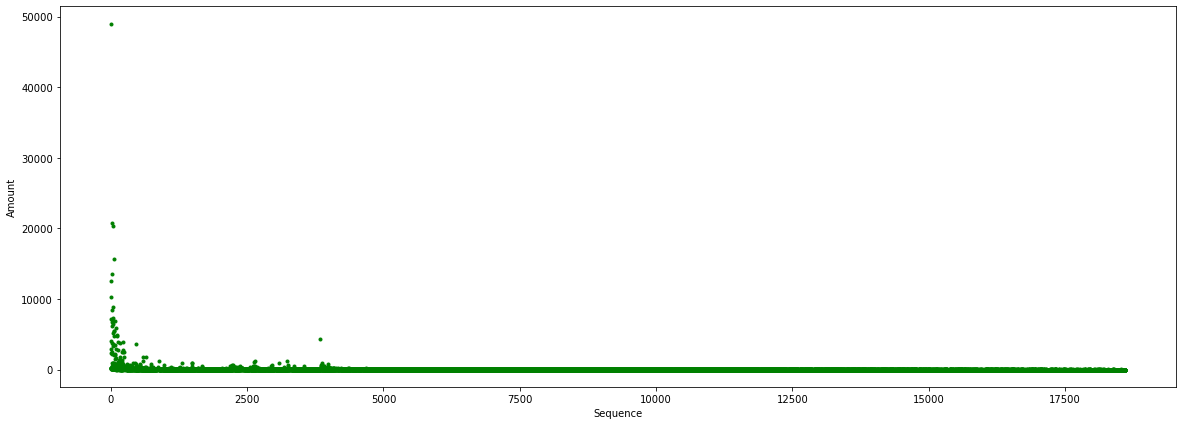

,id,expense_description,amount,expense_code,expense_class_by_code,expense_class_by_expert,description,class,y_class,binary_class,y_binary_class
0,67968997,proveniente de despesa com servicos tecnicos e...,7400.00,33903401,AJ,AC,proveniente de despesa com servicos tecnicos e...,AC,0,Y,1
1,67882216,despesa que se empenha proveniente ao 3º termo...,14498.00,33903499,OUTROS,AC,despesa que se empenha proveniente ao 3o termo...,AC,0,Y,1
...,...,...,...,...,...,...,...,...,...,...,...
17114,68239015,valor que se empenha para ocorrer a despesa co...,1293.00,33903026,N,N,valor que se empenha para ocorrer a despesa co...,N,3,N,0
17115,68345685,despesa com pagamento de bolsa de estudo (parc...,3885.61,33903608,N,N,despesa com pagamento de bolsa de estudo (parc...,N,3,N,0


In [5]:
loaded_data = load_data("tcm_expenses.xlsx")
freq = words_frequency(loaded_data, 'description')
words_distribution(loaded_data, 'description')
words_scatter(freq)
loaded_data

# Preprocessing

All dataset:  (17116, 11)
After removing duplicates:  (17109, 11)
After discarding no letters rows (17109, 11)


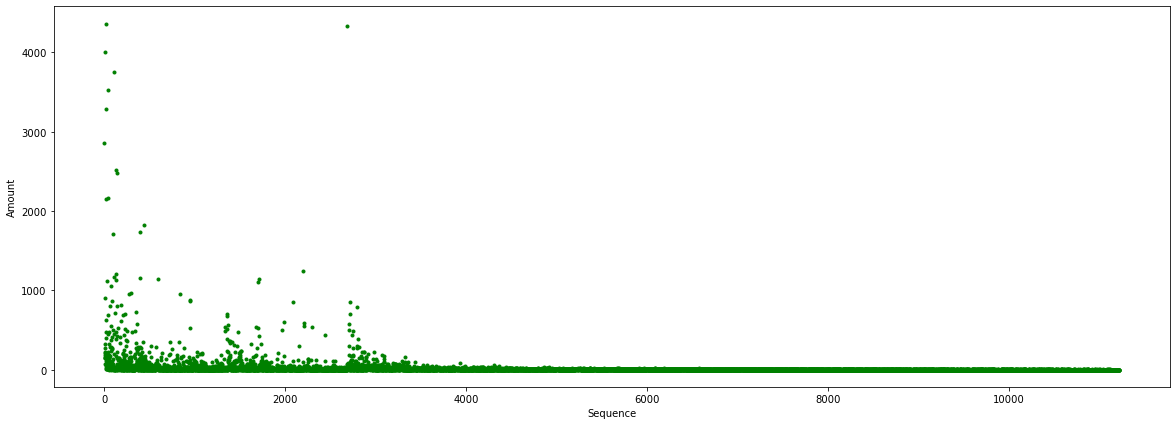

In [6]:
dataset = data_cleaning(loaded_data, 'description', remove_stop_words=True)
frequency_after_data_cleaning = words_frequency(dataset, 'description')
words_scatter(frequency_after_data_cleaning)

In [7]:
frequency_after_data_cleaning.sort_values(by=['Frequency'] )

,Word,Frequency,Amount
11213,britto,1,6
4554,ery,1,3
...,...,...,...
2680,aquisicao,4328,9
14,n,4364,1


array([[<AxesSubplot:title={'center':'Frequency'}>,
        <AxesSubplot:title={'center':'Amount'}>]], dtype=object)

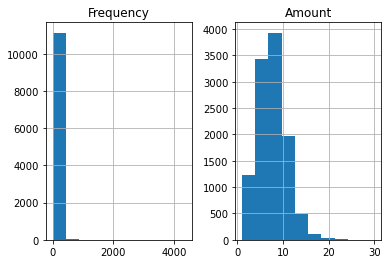

In [8]:
frequency_after_data_cleaning.hist()

## Spliting the data

In [9]:
folds = split_data(dataset)
print_amount_by_fold(folds)
print('\n\nSample Distribution - MULTICLASS\n')
print_sample_distribution(folds, 'class')

print('\n\nSample Distribution - BINARY\n')
print_sample_distribution(folds, 'binary_class')


Splitint the dataset into k= 10

Samples by Fold

Fold: 1 - 1711
Fold: 2 - 1711
Fold: 3 - 1711
Fold: 4 - 1711
Fold: 5 - 1711
Fold: 6 - 1711
Fold: 7 - 1711
Fold: 8 - 1711
Fold: 9 - 1711
Fold: 10 - 1710





Sample Distribution - MULTICLASS


Distribution by Fold

Fold: 1
N         1381
PA_PIP     224
CRED        74
AC          23
AJ           9
Name: class, dtype: int64 

Fold: 2
N         1387
PA_PIP     243
CRED        66
AJ          10
AC           5
Name: class, dtype: int64 

Fold: 3
N         1404
PA_PIP     224
CRED        64
AC          10
AJ           9
Name: class, dtype: int64 

Fold: 4
N         1361
PA_PIP     265
CRED        63
AC          14
AJ           8
Name: class, dtype: int64 

Fold: 5
N         1394
PA_PIP     237
CRED        62
AC          12
AJ           6
Name: class, dtype: int64 

Fold: 6
N         1368
PA_PIP     251
CRED        78
AC          10
AJ           4
Name: class, dtype: int64 

Fold: 7
N         1382
PA_PIP     232
CRED        74
AC          14
AJ 

# Experiments

In [32]:
#Definitions
models = [LogisticRegression(),  SVC() , MultinomialNB()]
classes = {'multiclass': ['y_class', lbl_multiclass], 'binary': ['y_binary_class', lbl_binary]}

metrics_all_models = list()

for approach, lbl_config in classes.items():
    class_attribute = lbl_config[0]
    encoder = lbl_config[1]
    for model in models:
        print('#'*70)
        print('EXPERIMENT -> ', 'Approach: ', approach, 'Model: ', model)
        print('#'*70)
        folds_return = prediction(model, folds, class_attribute, lbl_encoder=encoder)
        metrics_model = [str(model),approach]
        metrics_model.extend(get_metrics(pd.concat(folds_return), class_attribute, encoder, show=True))
        metrics_all_models.append(metrics_model)

######################################################################
EXPERIMENT ->  Approach:  multiclass Model:  LogisticRegression()
######################################################################

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      96   1     0      0       0
AJ       1  64     0      4       0
CRED     0   0   559     32       3
N       26  29   130  13635     217
PA_PIP   0   0     1    108    2203



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.99      0.78      0.87       123
          AJ       0.93      0.68      0.79        94
        CRED       0.94      0.81      0.87       690
           N       0.97      0.99      0.98     13779
      PA_PIP       0.95      0.91      0.93      2423

    accuracy                           0.97     17109
   macro avg       0.96      0.83      0.89     17109
weighted avg  

In [33]:
pd.set_option('display.max_rows', None)
df_results = pd.DataFrame(metrics_all_models, columns=['Model', 'Approach', 'Accuracy', 'Precision', 'Recall', 'F1', 'All Metrics'])
df_results

,Model,Approach,Accuracy,Precision,Recall,F1,All Metrics
0,LogisticRegression(),multiclass,0.97,0.96,0.83,0.89,"{'AC': {'precision': 0.9896907216494846, 'reca..."
1,SVC(),multiclass,0.97,0.97,0.87,0.91,"{'AC': {'precision': 0.9814814814814815, 'reca..."
2,MultinomialNB(),multiclass,0.92,0.56,0.41,0.44,"{'AC': {'precision': 0.0, 'recall': 0.0, 'f1-s..."
3,LogisticRegression(),binary,0.97,0.96,0.93,0.95,"{'N': {'precision': 0.9780309749607696, 'recal..."
4,SVC(),binary,0.98,0.98,0.96,0.97,"{'N': {'precision': 0.9859492803289924, 'recal..."
5,MultinomialNB(),binary,0.96,0.94,0.90,0.92,"{'N': {'precision': 0.96527683768783, 'recall'..."


In [42]:
df_results[df_results.Model == 'SVC()']

,Model,Approach,Accuracy,Precision,Recall,F1,All Metrics
1,SVC(),multiclass,0.97,0.97,0.87,0.91,"{'AC': {'precision': 0.9814814814814815, 'reca..."
4,SVC(),binary,0.98,0.98,0.96,0.97,"{'N': {'precision': 0.9859492803289924, 'recal..."


In [17]:
type(df_results.Model)

sklearn.svm._classes.SVC

In [20]:
instance of


SyntaxError: invalid syntax (<ipython-input-20-c38c00a51965>, line 1)

In [28]:
str(df_results.Model)

'0    LogisticRegression()\n1                   SVC()\n2         MultinomialNB()\n3    LogisticRegression()\n4                   SVC()\n5         MultinomialNB()\nName: Model, dtype: object'